# Vehicle Routing Problem with Time Windows (VRPTW)

Many vehicle routing problems involve scheduling visits to customers who are only available during specific time windows.These problems are known as vehicle routing problems with time windows (VRPTWs).

Remondis (Germany): Remondis is a global waste management company, operating in over 30 countries worldwide. The company provides collection, recycling, and disposal services for various types of waste, including hazardous waste and electronic waste.

In this project, our goal is to collect the garbage from 17 points of 5 zones in Munich by three Remondis trucks in a maximum of 45 minutes.

For finding the time matrix, the Google Map API is used so it is necessary to use your key_api. If you do not have one, please go to the following site: https://mapsplatform.google.com/pricing/

### Importing libraries

In [7]:
# Import the necessary libraries
from datetime import datetime
import googlemaps as gmaps
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

### Defining the location

In [18]:
# Define the city you are interested in
city = 'Munich, Germany'

# Download the road network data for the city
graph = ox.graph_from_place(city, network_type='drive')

### Creating time matrix by Google Map API

In [39]:
# Define the coordinates of the points you're interested in
#Depot
center_point = (48.19743439292945, 11.401160397262322)

#Zone 1
point_1 = (48.11535544923641, 11.477062522733089)
point_2 = (48.10849039213093, 11.475839715678593)
point_3 = (48.108755891272125, 11.4799615650615)
point_4 = (48.111050052816154, 11.485608918928401)

#Zone 2
point_5 = (48.196957789759466, 11.458104816266546)
point_6 = (48.19431639932179, 11.46171249627061)

#Zone 3
point_7 = (48.20105733955519, 11.608123154333553)
point_8 = (48.201466310462465, 11.61157296044604)
point_9 = (48.203004308806364, 11.609861713953054)


#Zone 4
point_10 = (48.132010173380685, 11.576620339530713)
point_11 = (48.12869555966337, 11.575552843369266)
point_12 = (48.1272071951607, 11.582641609265657)
point_13 = (48.13172856996234, 11.588313396787646)
point_14 = (48.13439695887626, 11.585922766946329)

#Zone 5
point_15 = (48.10904134686863, 11.639055768915727)
point_16 = (48.109014077889526, 11.650212719028934)
point_17 = (48.107735464824366, 11.657725499911997)



# Define your API key
api_key = 'your API key'

# Define the list of points
points = [center_point, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8,
          point_9, point_10, point_11, point_12, point_13, point_14, point_15, point_16, point_17]

# Initialize the time matrix with NaN values
time_matrix = np.full((len(points), len(points)), np.nan)

# Loop over all pairs of points and calculate the travel time
for i in range(len(points)):
    for j in range(len(points)):
        if i != j:
            # Use Google Maps Distance Matrix API to get the travel time
            gmaps_client = googlemaps.Client(api_key)
            result = gmaps_client.distance_matrix(origins=points[i],
                                       destinations=points[j],
                                       mode='driving',
                                       departure_time='now',
                                       traffic_model='best_guess')
            # Extract the travel time from the API result and store it in the time matrix
            time_matrix[i, j] = result['rows'][0]['elements'][0]['duration']['value']

# Print the time matrix
print(time_matrix)

[[  nan  894. 1002. 1059. 1087.  758.  793. 1248. 1254. 1317. 1895. 1680.
  1701. 1938. 1854. 1945. 2011. 2077.]
 [1200.   nan  108.  165.  220. 1384. 1419. 1580. 1586. 1648. 1503. 1288.
  1309. 1546. 1479. 1552. 1619. 1685.]
 [1111.  176.   nan   58.  138. 1295. 1330. 1491. 1497. 1559. 1443. 1206.
  1227. 1465. 1398. 1471. 1538. 1603.]
 [1174.  260.   68.   nan   80. 1358. 1392. 1553. 1733. 1796. 1363. 1148.
  1169. 1407. 1340. 1413. 1479. 1545.]
 [1191.  199.  157.   89.   nan 1376. 1410. 1581. 1587. 1649. 1301. 1087.
  1108. 1345. 1278. 1351. 1418. 1484.]
 [ 727. 1160. 1269. 1326. 1353.   nan   73.  995. 1001. 1064. 1814. 1817.
  1810. 1934. 1601. 1967. 2021. 2087.]
 [ 764. 1197. 1306. 1362. 1390.  100.   nan 1095. 1101. 1164. 2150. 1917.
  1910. 2009. 1701. 2068. 2123. 2187.]
 [1501. 1708. 1817. 1873. 1901. 1147. 1218.   nan   67.   67. 1228. 1231.
  1224. 1348. 1015. 1381. 1435. 1522.]
 [1384. 1592. 1700. 1757. 1784. 1030. 1101.   68.   nan  121. 1097. 1099.
  1092. 1216.  884. 12

In [45]:
# Get the nodes corresponding to the points
nodes = []
for point in points:
    node = ox.distance.nearest_nodes(graph, point[1], point[0])
    nodes.append(node)

In [40]:
converted_time_matrix = np.nan_to_num(time_matrix)
converted_time_matrix /= 60
converted_time_matrix = np.round(converted_time_matrix)

### Plotting

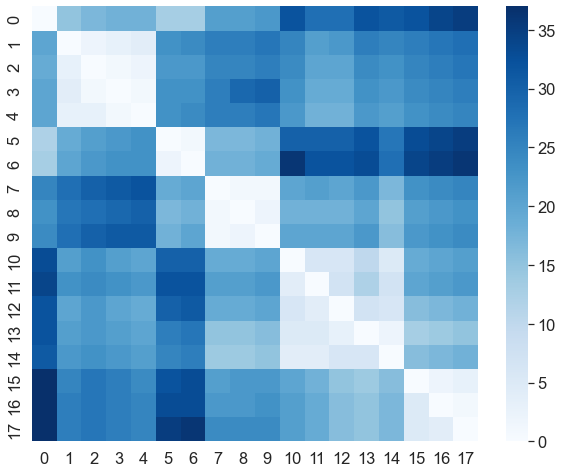

In [43]:
# plotting the heatmap of distance matrix
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

sns.heatmap(converted_time_matrix, cmap="Blues")
plt.show()

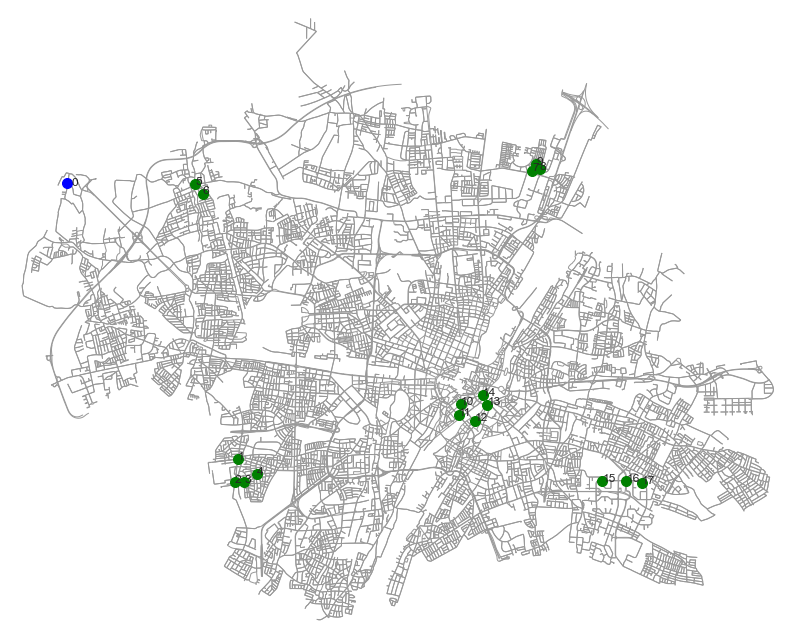

In [46]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=100, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)


ax.axis('off')
plt.show()

### Create the data

In [72]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = converted_time_matrix
    data['time_windows'] = [
        (0, 5),  # depot
        (0, 45),  # 1
        (0, 45),  # 2
        (0, 45),  # 3
        (0, 45),  # 4
        (0, 45),  # 5
        (0, 45),  # 6
        (0, 45),  # 7
        (0, 45),  # 8
        (0, 45),  # 9
        (0, 45),  # 10
        (0, 45),  # 11
        (0, 45),  # 12
        (0, 45),  # 13
        (0, 45),  # 14
        (0, 45),  # 15
        (0, 45),  # 16
        (0, 45),  # 17
    ]
    data['num_vehicles'] = 3
    data['depot'] = 0
    return data

In [73]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

### Time callback

In [74]:
def time_callback(from_index, to_index):
    """Returns the travel time between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Set the cost of travel

In [75]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Add time window constraints

In [76]:
time = 'Time'
routing.AddDimension(
    transit_callback_index,
    300,  # allow waiting time
    300,  # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    time)
time_dimension = routing.GetDimensionOrDie(time)
# Add time window constraints for each location except depot.
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == data['depot']:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
# Add time window constraints for each vehicle start node.
depot_idx = data['depot']
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(
        data['time_windows'][depot_idx][0],
        data['time_windows'][depot_idx][1])
for i in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i)))
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.End(i)))

### Set search parameters (PATH_CHEAPEST_ARC)

Here I choose the PATH_CHEAPEST_ARC, however you can try the other methods that are defined in: https://developers.google.com/optimization/routing/routing_options#first_solution_strategy

In [77]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

### Add the solution printer

In [78]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                    solution.Min(time_var),
                                                    solution.Max(time_var))
        plan_output += 'Time of the route: {}min\n'.format(
            solution.Min(time_var))
        print(plan_output)
        total_time += solution.Min(time_var)
    print('Total time of all routes: {}min'.format(total_time))

### Solve and print the solution

In [79]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 215
Route for vehicle 0:
0 Time(0,0) -> 12 Time(28,28) -> 13 Time(35,35) -> 14 Time(37,37) -> 11 Time(41,41) -> 10 Time(45,45) -> 0 Time(78,78)
Time of the route: 78min

Route for vehicle 1:
0 Time(0,0) -> 1 Time(15,15) -> 2 Time(17,17) -> 3 Time(18,18) -> 4 Time(19,19) -> 15 Time(42,42) -> 16 Time(44,44) -> 17 Time(45,45) -> 0 Time(82,82)
Time of the route: 82min

Route for vehicle 2:
0 Time(0,0) -> 9 Time(22,22) -> 7 Time(23,23) -> 8 Time(24,24) -> 5 Time(41,41) -> 6 Time(42,42) -> 0 Time(55,55)
Time of the route: 55min

Total time of all routes: 215min


### creating list of routes

In [80]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

In [81]:
routes = get_routes(solution, routing, manager)
# Display the routes.
for i, route in enumerate(routes):
    print('Route', i+1, route)

Route 1 [0, 12, 13, 14, 11, 10, 0]
Route 2 [0, 1, 2, 3, 4, 15, 16, 17, 0]
Route 3 [0, 9, 7, 8, 5, 6, 0]


### Finall plot

C:\Users\fadak\AppData\Local\Temp/ipykernel_11244/302224623.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(route)-1)  # Create a colormap with the same length as the number of segments


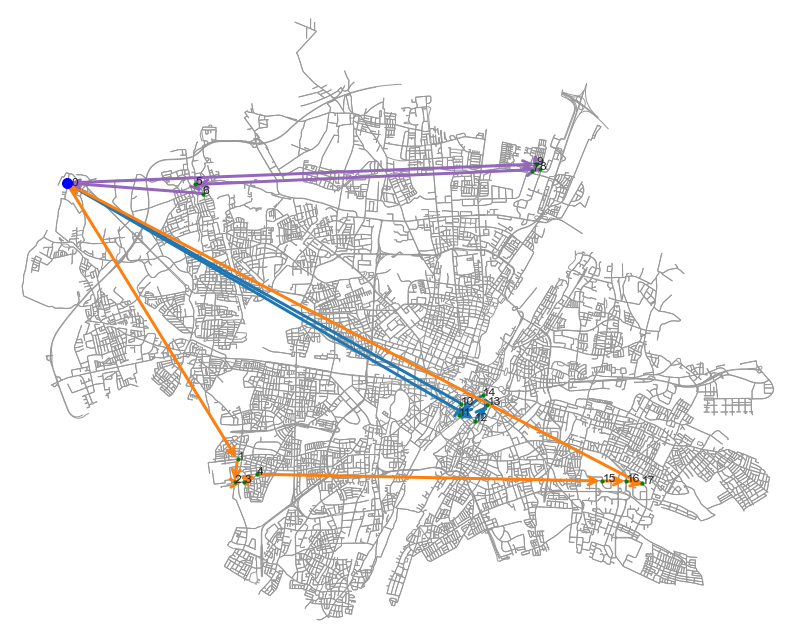

In [82]:
fig, ax = ox.plot_graph(graph, figsize=(
    14, 14), node_size=0, show=False, close=False)
ax.scatter(center_point[1], center_point[0], c='blue', s=100, zorder=2)
ax.scatter([graph.nodes[n]['x'] for n in nodes[1:]], [graph.nodes[n]['y']
           for n in nodes[1:]], c='green', s=10, zorder=2)
for i, node in enumerate(nodes):
    ax.text(graph.nodes[node]['x'], graph.nodes[node]
            ['y'], str(i), fontsize=12)
    
# Define the order of the nodes to connect
for j, route in enumerate(routes):
    cmap = cm.get_cmap('tab10', len(route)-1)  # Create a colormap with the same length as the number of segments
    color = cmap(j)  # Get the color for the current segment
    # Plot the lines between the nodes in the specified order
    for i in range(len(route) - 1):
        arrow = FancyArrowPatch((points[route[i]][1], points[route[i]][0]), (points[route[i+1]][1], points[route[i+1]][0]),
                                arrowstyle='->', color=color , linewidth=3, mutation_scale=20)
        ax.add_patch(arrow)    
        
# Set the limits of the x-axis and y-axis to zoom in on a specific part of the plot
# ax.set_xlim(2.3, 2.4)
# ax.set_ylim(48.83, 48.89)

ax.axis('off')
plt.show()

In [ ]:
array([[   0.,  894., 1002., 1059., 1087., 1006., 1054., 1048.,  952.,
         758.,  793.,  876.,  852., 1248., 1254., 1317., 1391., 1449.,
        1335., 1895., 1680., 1701., 1938., 1973., 2052., 2065., 1668.,
        1776., 1569., 1945., 2011., 2077., 2062., 2114., 2080.],
       [1200.,    0.,  108.,  165.,  220.,  257.,  346.,  404.,  332.,
        1384., 1419., 1484., 1433., 1580., 1586., 1648., 1722., 1780.,
        1667., 1503., 1288., 1309., 1546., 1479., 1591., 1562., 1258.,
        1273., 1158., 1552., 1619., 1685., 1670., 1722., 1688.],
       [1111.,  176.,    0.,   58.,  138.,  192.,  285.,  343.,  259.,
        1295., 1330., 1395., 1343., 1491., 1497., 1559., 1633., 1691.,
        1578., 1395., 1181., 1202., 1439., 1372., 1484., 1472., 1169.,
        1184., 1069., 1445., 1512., 1578., 1563., 1615., 1580.],
       [1174.,  260.,   68.,    0.,   80.,  134.,  227.,  284.,  270.,
        1358., 1392., 1458., 1406., 1553., 1559., 1622., 1696., 1754.,
        1640., 1363., 1148., 1169., 1407., 1340., 1451., 1589., 1232.,
        1247., 1132., 1413., 1479., 1545., 1531., 1582., 1548.],
       [1191.,  199.,  157.,   89.,    0.,   72.,  166.,  223.,  209.,
        1376., 1410., 1476., 1424., 1581., 1587., 1649., 1723., 1781.,
        1668., 1301., 1087., 1108., 1345., 1278., 1389., 1528., 1259.,
        1274., 1159., 1351., 1418., 1484., 1469., 1520., 1486.],
       [1108.,  115.,  202.,  133.,   70.,    0.,   90.,  147.,  125.,
        1293., 1327., 1393., 1341., 1485., 1491., 1553., 1627., 1685.,
        1572., 1246., 1031., 1052., 1289., 1222., 1334., 1472., 1163.,
        1178., 1063., 1296., 1362., 1428., 1414., 1465., 1431.],
       [1147.,  191.,  299.,  221.,  157.,   87.,    0.,   71.,  123.,
        1332., 1366., 1432., 1380., 1488., 1494., 1557., 1631., 1689.,
        1575., 1333., 1118., 1139., 1376., 1309., 1421., 1470., 1166.,
        1181., 1066., 1383., 1449., 1515., 1501., 1552., 1518.],
       [1166.,  260.,  346.,  278.,  214.,  145.,   69.,    0.,  135.,
        1351., 1385., 1451., 1399., 1416., 1422., 1485., 1559., 1617.,
        1503., 1287., 1072., 1093., 1330., 1263., 1375., 1398., 1095.,
        1110.,  995., 1336., 1403., 1469., 1454., 1506., 1472.],
       [1031.,  174.,  283.,  268.,  212.,  132.,  122.,  126.,    0.,
        1216., 1250., 1316., 1264., 1411., 1417., 1480., 1554., 1612.,
        1498., 1316., 1101., 1122., 1359., 1292., 1469., 1393., 1089.,
        1104.,  989., 1365., 1432., 1498., 1483., 1535., 1501.],
       [ 727., 1160., 1269., 1326., 1353., 1273., 1321., 1314., 1219.,
           0.,   73.,  119.,  177.,  995., 1001., 1064., 1138., 1196.,
        1082., 1742., 1871., 1738., 1747., 1529., 1595., 1642., 1536.,
        1353., 1326., 1894., 1949., 2015., 2012., 2064., 2017.],
       [ 764., 1197., 1306., 1362., 1390., 1310., 1357., 1351., 1256.,
         100.,    0.,   80.,  104., 1095., 1101., 1164., 1238., 1296.,
        1182., 1779., 1781., 1775., 1784., 1566., 1632., 1679., 1573.,
        1390., 1363., 1931., 1986., 2052., 2049., 2101., 2054.],
       [ 837., 1263., 1371., 1428., 1456., 1375., 1423., 1417., 1321.,
         144.,   80.,    0.,  104., 1131., 1137., 1200., 1274., 1332.,
        1218., 1813., 1816., 1809., 1819., 1600., 1667., 1713., 1607.,
        1425., 1397., 1966., 2020., 2086., 2084., 2135., 2089.],
       [ 867., 1224., 1332., 1389., 1417., 1336., 1384., 1378., 1282.,
         203.,  106.,  107.,    0., 1203., 1209., 1271., 1345., 1403.,
        1290., 1829., 1831., 1824., 1834., 1616., 1682., 1695., 1589.,
        1406., 1378., 1981., 2036., 2102., 2099., 2151., 2104.],
       [1501., 1502., 1611., 1639., 1576., 1516., 1502., 1433., 1550.,
        1147., 1218., 1263., 1321.,    0.,   67.,   67.,  204.,  219.,
         106., 1228., 1231., 1224., 1234., 1015., 1082., 1100., 1200.,
        1094., 1203., 1381., 1435., 1501., 1499., 1551., 1504.],
       [1384., 1370., 1479., 1507., 1444., 1385., 1370., 1301., 1418.,
        1030., 1101., 1147., 1205.,   68.,    0.,  121.,  204.,  271.,
         157., 1097., 1099., 1092., 1102.,  884.,  950.,  968., 1068.,
         962., 1071., 1249., 1304., 1369., 1422., 1419., 1372.],
       [1465., 1450., 1559., 1587., 1524., 1465., 1450., 1381., 1498.,
        1110., 1181., 1227., 1285.,   54.,   92.,    0.,  132.,  261.,
         148., 1177., 1179., 1172., 1182.,  964., 1030., 1048., 1148.,
        1042., 1151., 1329., 1384., 1450., 1502., 1554., 1452.],
       [1527., 1513., 1622., 1650., 1587., 1528., 1513., 1444., 1561.,
        1173., 1244., 1290., 1348.,  175.,  203.,  117.,    0.,  382.,
         268., 1240., 1242., 1235., 1245., 1027., 1093., 1111., 1211.,
        1105., 1214., 1392., 1447., 1512., 1510., 1617., 1515.],
       [1614., 1599., 1708., 1737., 1673., 1614., 1599., 1530., 1648.,
        1259., 1330., 1376., 1434.,  289.,  323.,  208.,  427.,    0.,
         153., 1326., 1328., 1322., 1331., 1113., 1179., 1197., 1297.,
        1191., 1301., 1478., 1533., 1599., 1596., 1648., 1601.],
       [1461., 1446., 1555., 1583., 1520., 1461., 1446., 1377., 1494.,
        1106., 1177., 1223., 1281.,  136.,  169.,   55.,  304.,  114.,
           0., 1173., 1175., 1168., 1178.,  960., 1026., 1044., 1144.,
        1038., 1147., 1325., 1380., 1446., 1443., 1550., 1448.],
       [1954., 1275., 1351., 1283., 1219., 1160., 1248., 1199., 1285.,
        1802., 1807., 1852., 1889., 1147., 1153., 1216., 1290., 1348.,
        1234.,    0.,  341.,  330.,  487.,  310.,  261.,  380.,  576.,
         616.,  622., 1111., 1176., 1242., 1229., 1280., 1244.],
       [2038., 1359., 1435., 1367., 1303., 1244., 1332., 1282., 1369.,
        1886., 1891., 1936., 1973., 1231., 1237., 1300., 1374., 1432.,
        1318.,  236.,    0.,  413.,  570.,  394.,  344.,  464.,  660.,
         700.,  706., 1194., 1260., 1326., 1312., 1364., 1328.],
       [1896., 1218., 1293., 1225., 1162., 1103., 1190., 1141., 1228.,
        1795., 1800., 1845., 1882., 1140., 1146., 1209., 1283., 1341.,
        1227.,  370.,  258.,    0.,  430.,  347.,  461.,  597.,  753.,
         766.,  853.,  958., 1024., 1089., 1076., 1128., 1092.],
       [1922., 1244., 1319., 1251., 1188., 1128., 1216., 1167., 1254.,
        1568., 1572., 1618., 1655.,  913.,  919.,  982., 1056., 1114.,
        1000.,  319.,  284.,  176.,    0.,  120.,  223.,  370.,  645.,
         539.,  648.,  787.,  852.,  918.,  905.,  957.,  921.],
       [1961., 1369., 1444., 1376., 1312., 1253., 1341., 1292., 1379.,
        1499., 1504., 1550., 1586.,  845.,  851.,  913.,  987., 1045.,
         932.,  213.,  259.,  252.,  341.,    0.,  125.,  245.,  576.,
         471.,  580.,  965., 1031., 1097., 1083., 1135., 1099.],
       [2003., 1455., 1530., 1462., 1399., 1339., 1427., 1378., 1465.,
        1541., 1546., 1592., 1628.,  887.,  893.,  955., 1029., 1087.,
         974.,  285.,  395.,  388.,  396.,  143.,    0.,  120.,  587.,
         440.,  552., 1031., 1096., 1162., 1149., 1200., 1165.],
       [2107., 1550., 1626., 1558., 1494., 1435., 1523., 1473., 1560.,
        1645., 1649., 1695., 1732.,  990.,  996., 1059., 1133., 1191.,
        1077.,  401.,  490.,  484.,  529.,  276.,  166.,    0.,  680.,
         534.,  646., 1147., 1212., 1278., 1265., 1317., 1281.],
       [1940., 1198., 1307., 1335., 1272., 1213., 1198., 1129., 1246.,
        1612., 1617., 1662., 1657., 1065., 1071., 1134., 1208., 1266.,
        1152.,  667.,  756.,  749.,  770.,  547.,  432.,  445.,    0.,
         247.,  357., 1278., 1333., 1399., 1396., 1448., 1401.],
       [1795., 1092., 1201., 1229., 1166., 1107., 1092., 1023., 1140.,
        1370., 1375., 1420., 1415.,  987.,  993., 1056., 1129., 1188.,
        1074.,  588.,  678.,  684.,  691.,  468.,  354.,  367.,  228.,
           0.,  115., 1200., 1254., 1320., 1372., 1424., 1323.],
       [1711., 1017., 1125., 1154., 1090., 1031., 1016.,  947., 1065.,
        1287., 1291., 1337., 1332., 1087., 1093., 1155., 1229., 1288.,
        1174.,  688.,  753.,  784.,  791.,  568.,  454.,  467.,  291.,
         113.,    0., 1300., 1354., 1420., 1472., 1524., 1423.],
       [2201., 1523., 1598., 1530., 1467., 1408., 1495., 1446., 1533.,
        1890., 1895., 1941., 1978., 1236., 1242., 1304., 1378., 1436.,
        1323., 1186., 1099.,  915.,  867.,  987., 1090., 1236., 1292.,
        1186., 1295.,    0.,  125.,  191.,  243.,  295.,  193.],
       [2220., 1542., 1617., 1549., 1485., 1426., 1514., 1465., 1552.,
        1993., 1998., 2043., 2080., 1338., 1344., 1407., 1481., 1539.,
        1425., 1235., 1200.,  975.,  916., 1035., 1139., 1285., 1394.,
        1288., 1397.,  287.,    0.,   65.,  117.,  169.,   68.],
       [2224., 1545., 1621., 1552., 1489., 1430., 1518., 1468., 1555.,
        2049., 2054., 2099., 2136., 1394., 1400., 1463., 1537., 1595.,
        1481., 1238., 1121.,  979.,  919., 1039., 1142., 1289., 1450.,
        1344., 1454.,  291.,  230.,    0.,   52.,  110.,  198.],
       [2171., 1492., 1568., 1500., 1436., 1377., 1465., 1416., 1502.,
        1992., 1997., 2042., 2079., 1337., 1343., 1406., 1480., 1538.,
        1424., 1186., 1151.,  926.,  866.,  986., 1090., 1236., 1393.,
        1287., 1396.,  238.,  177.,   93.,    0.,   52.,  140.],
       [2230., 1551., 1627., 1559., 1495., 1436., 1524., 1474., 1561.,
        2022., 2026., 2072., 2109., 1367., 1373., 1436., 1510., 1568.,
        1454., 1245., 1210.,  985.,  925., 1045., 1149., 1295., 1423.,
        1317., 1426.,  297.,  236.,  169.,   54.,    0.,   88.],
       [2161., 1482., 1558., 1489., 1426., 1367., 1455., 1405., 1492.,
        1933., 1938., 1984., 2020., 1279., 1285., 1347., 1421., 1479.,
        1366., 1175., 1140.,  916.,  856.,  976., 1079., 1226., 1334.,
        1229., 1338.,  228.,  202.,   81.,  133.,  102.,    0.]])